In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

import json
import random
from datetime import datetime
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import re

print(tf.__version__)

2.1.0-rc0


In [2]:
SEED = 2019
tf.random.set_seed(SEED)

classes = ['0',             # 0
           '1',             # 1
           '10',            # 2
           '2',             # 3
           '3',             # 4
           '4',             # 5
           '5',             # 6
           '6',             # 7
           '7',             # 8
           '8',             # 9
           '9',             # 10
           'no',            # 11
           'yes']           # 12

PATH = "/kaggle/input/ann-and-dl-vqa/dataset_vqa"

num_labels = 13
batch_size = 64

MAX_SEQUENCE_LENGTH = 32
IMG_HEIGHT, IMG_WIDTH = 320, 480


## Load data from json files

In [3]:
with open(os.path.join(PATH, 'train_data.json'), 'r') as f:
    train_data = json.load(f)
f.close()

with open(os.path.join(PATH, 'test_data.json'), 'r') as f:
    test_data = json.load(f)
f.close()

train_data = train_data['questions']
test_data = test_data['questions']

train_dataset_size = len(train_data) # number of questions --> 259492


### format of data

In [4]:
train_data[1:3]

[{'answer': '0',
  'image_filename': 'CLEVR_train_000000.png',
  'question': 'How many gray matte things are on the right side of the small rubber cube behind the large brown thing left of the cyan thing?'},
 {'answer': 'yes',
  'image_filename': 'CLEVR_train_000000.png',
  'question': 'Are there any other things that have the same size as the brown shiny sphere?'}]

# Data Generator

## Tokenizer
The tokenizer translate question made of words into vectors of numbers.
by default the tokenizer get rids of punctuation. This has been avoided by splitting words base only on spaces. 

Answers are preprocessed so as to divide punctuation from words by at least a space.
The number of terms that the tokenizer can be encoded, has to be fixed before start using it. For such a reason questions are extracted and fed into the tokenizer so it can determine all the parametrs that are necessary for its usage. 

In [5]:
def searate_punctuation_from_words(string):
    to_tokenize = '.,:;!?'
    return re.sub(r'(['+to_tokenize+'])', r' \1 ', string)

for i,q in enumerate(train_data):
    train_data[i]['question'] = searate_punctuation_from_words(train_data[i]['question'])

for i,q in enumerate(test_data):
    test_data[i]['question'] = searate_punctuation_from_words(test_data[i]['question'])
    
    


In [6]:
import sys

BASE_DIR = '/kaggle/input/'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove6b')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20-newsgroup-original', '20_newsgroup')
MAX_SEQUENCE_LENGTH = 64
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100


# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
t = Tokenizer(num_words=MAX_NUM_WORDS)
t.fit_on_texts(texts)
sequences = t.texts_to_sequences(texts)

word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)



Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 19997 texts.
Found 174074 unique tokens.
Preparing embedding matrix.


In [7]:
#example of tokenizer usage 
t.texts_to_sequences(['the tiny metallic cylinder ?'])


[[1, 4512, 13240, 5013]]

### MyDataset
this class hide the steps that led to the dataset creation and the split between validation and training set.
This class can be supplied with :
- a predicate that filters the element in json. It is used to acquire a subset of questions related to a certain answer
- a field that indicates what part of each object contained in json variable has to be taken
- a function 'funct' that is executed of the field extracted before building the dataset

In [16]:

class myDataset(tf.data.Dataset):
   
    def __new__(self, json, field, output_shapes, output_types, validation_split=0.0,
                seed=None, subset='training', funct = None, filt=None , verbose=False, randomize=True):
        
        #1. set seed if available
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
        #2. divide questions in two sets randomly.
        #print(os.listdir(basepath))
        question_indices = range(len(json))
        question_indices = np.array(question_indices)   
        if(randomize):
            np.random.shuffle(question_indices)

        split_indx = round( validation_split * len(question_indices) )
        #3. take the part corresponding to to either the validation
        # or the training subset
        if subset == 'validation':
            self.subset = json[:split_indx]
            self.number_of_items = split_indx
            
        else :
            self.subset = json[split_indx:]
            self.number_of_items =len(json)- split_indx
        
        if(verbose):
            #print number of items carried
            print( self.number_of_items, 'items ingested')
            #print field
            print( 'taking field', field)
        
        #if present use a filter
        if filt is not None:
            if(verbose):
                 print('executed:',filt)
            self.subset = filter(filt, self.subset)
            
        #extract field from json
        self.subset = list(map(lambda el: el[field], self.subset))
        
        #define an high order function that will be passed 
        # to tf.data.Dataset.from_generator to obtain the dataset.
        def get_generator(funct, randomize):
            def generator(subset):
                
                res = subset
                
                if randomize:
                    np.random.shuffle(res)
                
                if funct is not None:
                    if(verbose):
                        print('executed:',funct)
                    res = map(funct, res)

                res = map(tf.convert_to_tensor, res)

                for el in iter(res):
                    yield el
                
            return generator
        
        generator = get_generator(funct, randomize)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes,
            args = (self.subset,)
        )
    
    def number_of_items(self):
        return self.number_of_items


### Create a evenly distributed dataset
To create a dataset that is not unbalanced w.r.t. the answers, in the initial steps we create different dataset for each answer. ~~Those are later recombined using [tf.data.experimental.sample_from_datasets](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets?version=stable).~~
Since with sample_from_dataset still answers are a bit umbalanced 

I thought it is better to create batch by extracting in a circular fashion from every dataset referring to a specific answer.To accomplish this [choose_from_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/choose_from_datasets)
was used.
result: 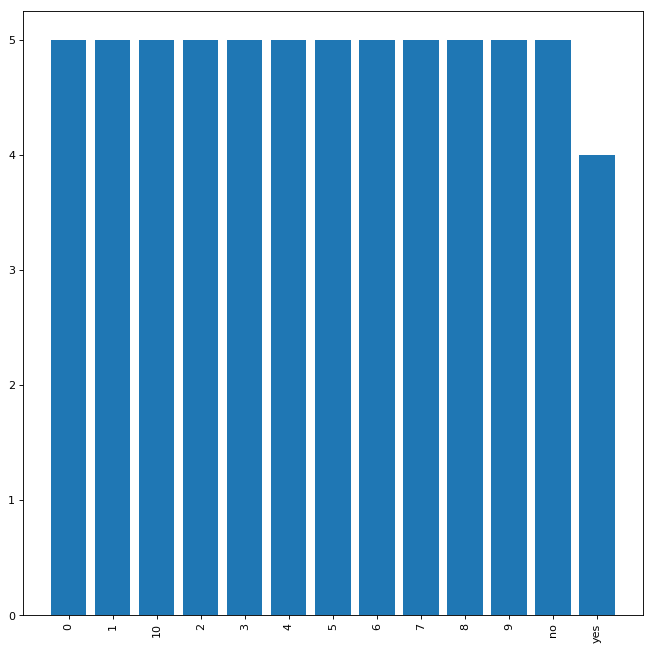

Each dataset for each answer is built by separated dataset. Why?
Each field of the answer is picked up separately so as to perform a specific preprocessing fucntion to the field we are considering.
Then Dataset of each field are recombined via [tf.data.Dataset.zip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable#zip).

In [17]:
#this function returns a dataset for a specific answer
def get_dataset_for_answer(ans, validation_split=0.2, subset='training'):
    #define a filter so as to pick up only a specific type of answer
    def get_answer_selector(ans):
        def answer_selector(el):
            return el['answer']==ans
        return answer_selector

    answer_selector = get_answer_selector(ans)
    
    #dataset containing questions
    #high order function to encode question
    def get_encoder_question(t):
        def question_encoder(text):
            #use tokenizer to encode the sequences
            sequences = t.texts_to_sequences([text.decode("utf-8")])
            sequences = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
            return sequences[0]
        return question_encoder
        
    question_encoder = get_encoder_question(t)
    #obtain the dataset containing questions
    training_steps,dataset_questions = myDataset(train_data,'question', 
                             output_shapes     = (MAX_SEQUENCE_LENGTH),
                             output_types      = tf.int32,
                             subset            = subset,
                             funct             = question_encoder, 
                             filt              = answer_selector,
                             validation_split  = validation_split, 
                             seed              = SEED)
    
    #dataset containing answers
    #high order function that encodes the answers with a custom format. 
    #This allows to tackle the problem both as a regression and a classification problem.
    
    def get_answer_encoder(classes):
        def answer_encoder(answer):
            answer = answer.decode('utf-8')
            res = np.zeros(4)

            if answer == 'yes':
                res[0] = 1
            elif answer == 'no':
                res[1] = 1
            else :
                res[2] = 1
                res[3] = int(answer)/10

            return res
        return answer_encoder
    answer_encoder = get_answer_encoder(classes)
    #obtain the dataset containing answers
    _,dataset_answer = myDataset(train_data,'answer', 
                             output_shapes    = (4),
                             output_types     = tf.float32,
                             subset           = subset,
                             funct            = answer_encoder, 
                             filt             = answer_selector,
                             validation_split = validation_split, 
                             seed             = SEED)

    #dataset containing images
    #high order function that load image from the disk and impose values between [0-1].
    def get_image_loader(basepath):
        def image_loader(path):
            path = os.path.join(basepath ,path.decode("utf-8"))

            img = Image.open(path)
            img = np.array(img)[:,:,:3]

            img = img * 1.0 / 255

            return img
        return image_loader
    image_loader = get_image_loader(os.path.join(PATH, 'train'))
    #obtain the dataset containing images
    _,dataset_images = myDataset(train_data,'image_filename', 
                             output_shapes   = (IMG_HEIGHT, IMG_WIDTH,3),
                             output_types    = tf.float32,
                             subset          = subset,
                             filt            = answer_selector,
                             funct           = image_loader, 
                             validation_split= validation_split, 
                             seed            = SEED)
    # ZIP datasets for a given answer
    dataset_input = tf.data.Dataset.zip((dataset_images,dataset_questions))
    dataset_input_target = tf.data.Dataset.zip((dataset_input,dataset_answer))
    number_steps = training_steps / batch_size 
    
    print('possible number of training steps',number_steps)
    #return the dataset for a given answer
    return dataset_input_target

#obtain a training/validation dataset for each answer
training_datasets = []
validation_datasets = []
for ans in classes:
    print('obtaining dataset for',ans)
    dataset_ans = get_dataset_for_answer(ans, subset='training')
    dataset_ans_val = get_dataset_for_answer(ans, subset='validation')
    
    training_datasets.append(dataset_ans.shuffle(10, reshuffle_each_iteration=True).repeat())
    validation_datasets.append(dataset_ans_val.shuffle(10, reshuffle_each_iteration=True).repeat())
    
#combine the datasets together 
choice_dataset1 = tf.data.Dataset.range(len(classes)).repeat()
choice_dataset2 = tf.data.Dataset.range(len(classes)).repeat()

train_dataset = tf.data.experimental.choose_from_datasets(training_datasets, choice_dataset1).batch( batch_size,drop_remainder=True )
valid_dataset = tf.data.experimental.choose_from_datasets(validation_datasets,choice_dataset2).batch( batch_size,drop_remainder=True )


obtaining dataset for 0
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 1
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 10
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 2
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 3
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 4
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 5
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 6
possible number of training steps 3243.65625
possible number of training steps 810.90625
obtaining dataset for 7
possible number of training steps 3243.65625
possible number of trainin

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   80  125 4512
   19    1  150  496   21    1  433 5013]
question ['how many tiny are the same color as the large cylinder']
image
answer (yes[binary], no[binary] , count[binary], number_regression[0-10]) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


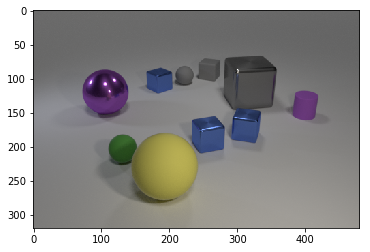

In [22]:
it = iter(train_dataset)


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   35  212    3 5795
   19  282  433  728  193   22 4554 1658]
question ['what number of cylinders are either large red things or gray objects']
image
answer (yes[binary], no[binary] , count[binary], number_regression[0-10]) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


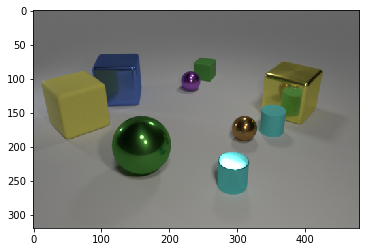

In [21]:
#example on how to obtain a data sample from the dataset

batch = next(it)
target_batch = batch[1]
input_batch  = batch[0]
sequences = input_batch[1]
images    = input_batch[0]
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])

print('answer (yes[binary], no[binary] , count[binary], number_regression[0-10])', target_batch[0])

# Model architecture

In [27]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential

def get_Vision_Model():
    # Define CNN for Image Input
    vision_model = Sequential()
    vision_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(8, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(16, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(24, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(32, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    return vision_model

'''def get_Vision_Model():
    vision_model = tf.keras.applications.vgg19.VGG19( include_top=False,weights='imagenet')
    vision_model.trainable = False
    return vision_model
    '''

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH,3), name='img_input')
vision_output = get_Vision_Model()(image_input)

# Define RNN for language input (batch_size, max_sequence_length)
question_input        = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input', dtype='int32')
embedded_question     = embedding_layer(question_input)
# embedding output shape = (batch_size, max_sequence, embedding_space_size )
# embedding output[batch_indx, time_step, specific_embedding_space_dimension]
embedded_question_dim = embedded_question.shape[2]

encoded_question      = LSTM(3*embedded_question_dim, return_sequences=True)(embedded_question)
cell_output_history, cell_output_final, cell_state_final  = LSTM(embedded_question_dim, return_sequences=True, return_state=True)(encoded_question)

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
encoded_question = final_memory_state
encoded_question , _ = BahdanauAttention(60)(encoded_question,whole_sequence_output)

print(encoded_question.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)
#attention based on LSTM context and CNN output:
class Attention(tf.keras.Model):
    def __init__(self, n_features):
        super(Attention, self).__init__()
        self.EXTRACT = tf.keras.layers.GlobalAveragePooling2D()
        #dense default activation is linear
        self.W1 = tf.keras.layers.Dense(1)
        self.SOFT = tf.keras.layers.Dense(n_features, activation='softmax')

    def call(self, features,hidden):
        #from features and hidden representation to a similarity factor
        mean_activation_per_feature = self.EXTRACT(features)
        hidden_per_feature          = self.W1(hidden)

        #obtain a similarity score
        #tf.multiply supports broadcasting https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
        score = tf.keras.layers.multiply([mean_activation_per_feature, hidden_per_feature])
        attention_weights =  self.SOFT(score)

        features_attentioned = tf.keras.layers.multiply([features, attention_weights])
        features_attentioned = tf.reduce_sum(features_attentioned, axis=3)

        return attention_weights, features_attentioned



    
attention_weights, feature1 = Attention(vision_output.shape[3])(vision_output,encoded_question)
_,feature2 = Attention(vision_output.shape[3])(vision_output,encoded_question)
_,feature3 = Attention(vision_output.shape[3])(vision_output,encoded_question)
_,feature4 = Attention(vision_output.shape[3])(vision_output,encoded_question)
encoded_image1 = Flatten()(feature1)
encoded_image2 = Flatten()(feature2)
encoded_image3 = Flatten()(feature1)
encoded_image4 = Flatten()(feature2)
# Combine CNN and RNN to create the final model
merged = tf.keras.layers.concatenate([encoded_question, encoded_image1, encoded_image2, encoded_image3, encoded_image4])
dense = Dense(64, activation='relu')(merged)
dropout = Dropout(0.3)(dense)

output_classification = Dense(3, activation='softmax')(dropout)#3 = [yes, no, regression]
output_regression     = Dense(1, activation='sigmoid')(dropout)#1 output 0-1 to mimic 0-10 answer
output = Concatenate()([output_classification, output_regression])
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

(None, 64, 100)
(None, 256)
(None, 256)
(None, 256)


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("text_input:0", shape=(None, 64), dtype=int32) at layer "text_input". The following previous layers were accessed without issue: []

In [ ]:
plot_model(vqa_model, show_shapes=True)

In [ ]:
vqa_model.summary()

## Custom loss
since has beem decided to tackle the problem as both a classification and regression problem a custom loss was required.

The output of the NN has been encoded as follows:
- binary 1hot encoding 'yes'
- binary 1hot encoding 'no'
- binary 1hot encoding 'regression_problem'
- regression output ranging from 0 to 1 , representing numbers between 0 to 10.

The loss function is a combination of categorical cross entropy and MSE. The MSE term is considered only when the expected answer refer to a counting problem, that is when the third one hot is active. 
inspiration from [FasterRCnn](https://arxiv.org/abs/1506.01497)

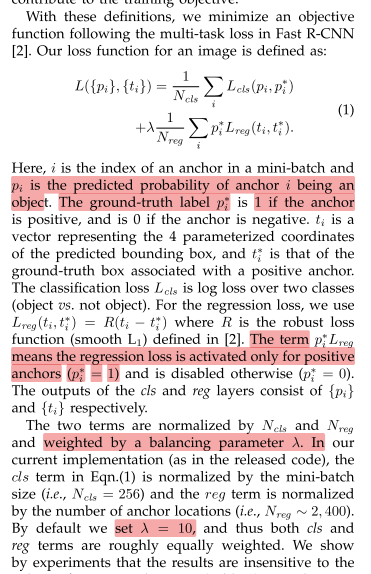

In [ ]:
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import categorical_crossentropy
# Function used to extract categorical and regression term when y related
# to a single sample
def custom_encod2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=0)
   
    return cat, 10*regr

# Function used to extract categorical and regression term when y related
# to a batch
def custom_encods2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=1)
   
    return cat, 10*regr

#custom loss
def loss(y_true, y_pred):
    #move from custom encoding to separated component (categorical and regression components)
    cat_y_true, regr_y_true = custom_encods2cat_reg(y_true)
    cat_y_pred, regr_y_pred = custom_encods2cat_reg(y_pred)
    # from t_true categorical extract the 1-hot that express whether the answer
    # was a regression or not for later usage
    
    _, cat_y_true_reg = tf.split(cat_y_true, [2, 1], axis=1)
    w = 1
    # sum the loss of two components categorical and regression
    # regression is only considered when the answer was truly related to regression (counting)
    # inspiration from FasterR-CNN with the loss related to bounding box regression and "objectness" measure
    reg_loss = cat_y_true_reg * w *mean_squared_error(regr_y_true, regr_y_pred)
    
    #reg_loss = cat_y_true_reg *w *tf.keras.losses.mean_absolute_error(regr_y_true, regr_y_pred)
    
    loss = categorical_crossentropy(cat_y_true, cat_y_pred) + reg_loss
    
    return loss

In [ ]:
#example of usage
print (loss([[0,0,1,0.1]], [[0,0,1,0.8]]))

print( loss([[0,0,1,0.1]], [[0,0.9,0,0.8]]))

## Custom metric
Since the encoding differs from the one used to evaluate the work on kaggle we have to
return to the original encoding before supply the tensors to categorical_accuracy function.


In [ ]:
from tensorflow.keras.metrics import categorical_accuracy
#Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a single sample
def custom_encod2cat(y):
    # extract categorical and regression terms out of the custom encoding
    cat_y, regr_y = custom_encod2cat_reg(y)
    #separate in from the categorical part of the output the one hot related to 
    # - indicates yes 
    # - indicates no
    # - indicates a regression
    cat_yes, cat_no ,cat_regr= tf.split(cat_y, [1,1,1], axis=0)
    
    # move from regression output to one hot between 11 classes
    regr_one_hot = tf.reshape(tf.one_hot( tf.cast(tf.math.round(regr_y), tf.uint8), 11), [-1])
    # multiply with one hot that indicates whether this was a regression problem or not
    # so as to eliminate regression one hot in case cat_regr is low
    regr_one_hot = cat_regr * regr_one_hot
    
    #rearrange one hots to reflect the output expected by the kaggle competition    
    reg_01, regr_29 ,regr_10= tf.split(regr_one_hot, [2,8,1], axis=0)
    categorical = tf.concat([reg_01, regr_10, regr_29, cat_no, cat_yes ], axis=0)
   
    return categorical

#Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a batch
def custom_encods2cat(ys):
    
    return tf.map_fn(custom_encod2cat, ys)
    
    

#custom metric "adapter"
def metric(y_true, y_pred):
    
    y_true = custom_encods2cat(y_true)
    y_pred = custom_encods2cat(y_pred)
    
    return categorical_accuracy(y_true, y_pred)

In [ ]:
#test of usage
for p in range(1,11):
    for num in range(11):
        assert np.argmax(custom_encod2cat([p/10 -0.1,p/10-0.1,p/10,num/10])) == classes.index(str(num)) 


In [ ]:
# Optimization parameters

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [metric]

# Compile Model (change the name for each model)
vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = vqa_model.fit(
              train_dataset.prefetch(3),
              steps_per_epoch = 400,
              epochs=40,
              validation_freq = 1,
              validation_data=valid_dataset.prefetch(2),
              validation_steps = 30
          )

In [ ]:
vqa_model.save_weights('weights.h5')

In [ ]:
with lst+Attention+2feature extracted by cnn(vgg19) and attention 
Train for 400 steps, validate for 30 steps
Epoch 1/40
400/400 [==============================] - 456s 1s/step - loss: 3.7495 - metric: 0.2298 - val_loss: 1.9585 - val_metric: 0.2859
Epoch 2/40
400/400 [==============================] - 434s 1s/step - loss: 2.7119 - metric: 0.2842 - val_loss: 6.2830 - val_metric: 0.1203
Epoch 3/40
400/400 [==============================] - 432s 1s/step - loss: 6.3343 - metric: 0.1217 - val_loss: 6.0117 - val_metric: 0.1245
Epoch 4/40
400/400 [==============================] - 457s 1s/step - loss: 3.5880 - metric: 0.1938 - val_loss: 2.7448 - val_metric: 0.2302
Epoch 5/40
400/400 [==============================] - 453s 1s/step - loss: 1.8468 - metric: 0.3146 - val_loss: 1.8292 - val_metric: 0.3375
Epoch 6/40
400/400 [==============================] - 441s 1s/step - loss: 1.5372 - metric: 0.3557 - val_loss: 1.6639 - val_metric: 0.3271
Epoch 7/40
400/400 [==============================] - 439s 1s/step - loss: 1.4580 - metric: 0.3636 - val_loss: 1.7018 - val_metric: 0.3208
Epoch 8/40
400/400 [==============================] - 436s 1s/step - loss: 1.3808 - metric: 0.3802 - val_loss: 1.4699 - val_metric: 0.3594
Epoch 9/40
400/400 [==============================] - 439s 1s/step - loss: 1.3452 - metric: 0.3828 - val_loss: 1.6619 - val_metric: 0.3448
Epoch 10/40
400/400 [==============================] - 439s 1s/step - loss: 1.3126 - metric: 0.3847 - val_loss: 1.5265 - val_metric: 0.3630
Epoch 11/40
400/400 [==============================] - 439s 1s/step - loss: 1.3005 - metric: 0.3909 - val_loss: 1.6439 - val_metric: 0.3500
Epoch 12/40
276/400 [===================>..........] - ETA: 2:05 - loss: 1.2393 - metric: 0.4021







In [ ]:
# Code snippet used in a first time to evaluate
# models' capabilities. In particular was used to try spotting correlations
# between errors both on the training and on the validation dataset.

def computeConfusion(dataset, max_num ):
    confusion_matrix = [[ 0 for i in range(0,len(classes))] for i in range(0,len(classes))];

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        sample = batch[0]
        labels = batch[1]
        for j,l in enumerate(labels):

            if(i > max_num):
                break;
    
            res = vqa_model.predict((tf.expand_dims(sample[0][j], axis=0), tf.expand_dims(sample[1][j], axis=0)) )

            expected = np.argmax(custom_encod2cat(l))

            predicted = np.argmax(custom_encods2cat(res)[0]);
            
            confusion_matrix[expected][predicted] +=1
            i+=1

    plotConfusionMatrix(confusion_matrix);
      
def plotConfusionMatrix(conf):
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    im = plt.imshow(conf)
    plt.yticks(range(0,len(classes)), labels=classes);
    plt.xticks(range(0,len(classes)), labels=classes, rotation='vertical' );
    plt.ylabel("expected");
    plt.xlabel("predicted");
    plt.gca().invert_yaxis()
    plt.colorbar();

    for y in range(len(conf)):
        for x in range(len(conf[y])):
            plt.text(x, y , '{:.0f}'.format(conf[y][x]),
                  color='w',horizontalalignment='center',
                  verticalalignment='center')


computeConfusion(train_dataset, 400);
computeConfusion(valid_dataset, 400);

In [ ]:
# The following code snippet was used to have an idea on 
# dataset distribution across the classes.
def plotDatasetDistribution(dataset, max_num ):
    classes_count = [0 for i in range(len(classes))]

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        labels = batch[1]
        for l in labels:
            if(i > max_num):
                break
            expected = np.argmax(custom_encod2cat(l))
            classes_count[expected]+=1
            i+=1
    #print(classes_count)
    plt.figure( figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k');
    plt.bar(range(len(classes)), classes_count )
    plt.xticks( ticks=range(len(classes)) ,labels=classes, rotation='vertical' )
    plt.show()

plotDatasetDistribution(train_dataset, 400)
plotDatasetDistribution(valid_dataset, 400)

In [ ]:
with smaller lstm and dense layer (indeed only 4 outputs)

In [ ]:
with small

Train for 50 steps, validate for 10 steps
Epoch 1/30
50/50 [==============================] - 65s 1s/step - loss: 6.5968 - metric: 0.1016 - val_loss: 5.6357 - val_metric: 0.1734
Epoch 2/30
50/50 [==============================] - 55s 1s/step - loss: 2.5773 - metric: 0.2172 - val_loss: 5.4351 - val_metric: 0.2094
Epoch 3/30
50/50 [==============================] - 56s 1s/step - loss: 1.8325 - metric: 0.2678 - val_loss: 4.8666 - val_metric: 0.1969
Epoch 4/30
50/50 [==============================] - 55s 1s/step - loss: 1.5462 - metric: 0.2947 - val_loss: 5.0142 - val_metric: 0.2109
Epoch 5/30
50/50 [==============================] - 56s 1s/step - loss: 1.1426 - metric: 0.3519 - val_loss: 6.0774 - val_metric: 0.1984
Epoch 6/30
50/50 [==============================] - 55s 1s/step - loss: 1.0680 - metric: 0.3422 - val_loss: 4.8745 - val_metric: 0.2031
Epoch 7/30
50/50 [==============================] - 55s 1s/step - loss: 1.0670 - metric: 0.3425 - val_loss: 5.9698 - val_metric: 0.2000
Epoch 8/30
50/50 [==============================] - 56s 1s/step - loss: 1.0138 - metric: 0.3556 - val_loss: 3.6938 - val_metric: 0.2031
Epoch 9/30
50/50 [==============================] - 56s 1s/step - loss: 0.7742 - metric: 0.3862 - val_loss: 4.2863 - val_metric: 0.1891
Epoch 10/30
50/50 [==============================] - 56s 1s/step - loss: 0.7781 - metric: 0.3872 - val_loss: 6.2379 - val_metric: 0.2062
Epoch 11/30
50/50 [==============================] - 56s 1s/step - loss: 0.7407 - metric: 0.3900 - val_loss: 4.9456 - val_metric: 0.2141
Epoch 12/30
50/50 [==============================] - 56s 1s/step - loss: 0.7796 - metric: 0.3972 - val_loss: 4.9762 - val_metric: 0.2219
Epoch 13/30
50/50 [==============================] - 56s 1s/step - loss: 0.7547 - metric: 0.4028 - val_loss: 4.6925 - val_metric: 0.2141
Epoch 14/30
50/50 [==============================] - 55s 1s/step - loss: 0.7250 - metric: 0.3966 - val_loss: 5.0020 - val_metric: 0.2516
Epoch 15/30
50/50 [==============================] - 56s 1s/step - loss: 0.6526 - metric: 0.4119 - val_loss: 7.2147 - val_metric: 0.2109
Epoch 16/30
50/50 [==============================] - 56s 1s/step - loss: 0.5645 - metric: 0.4253 - val_loss: 5.4546 - val_metric: 0.2203

In [ ]:
64 +64 LSTMs
16 32 64 cnn

Train for 50 steps, validate for 10 steps
Epoch 1/30
50/50 [==============================] - 118s 2s/step - loss: 6.3807 - metric: 0.1056 - val_loss: 4.7939 - val_metric: 0.1891
Epoch 2/30
50/50 [==============================] - 58s 1s/step - loss: 2.5472 - metric: 0.2294 - val_loss: 4.7299 - val_metric: 0.2000
Epoch 3/30
50/50 [==============================] - 59s 1s/step - loss: 1.9861 - metric: 0.2597 - val_loss: 5.0376 - val_metric: 0.1953
Epoch 4/30
50/50 [==============================] - 59s 1s/step - loss: 1.5225 - metric: 0.3056 - val_loss: 5.8408 - val_metric: 0.2047
Epoch 5/30
50/50 [==============================] - 58s 1s/step - loss: 1.1468 - metric: 0.3434 - val_loss: 6.3058 - val_metric: 0.1984
Epoch 6/30
50/50 [==============================] - 57s 1s/step - loss: 1.0833 - metric: 0.3428 - val_loss: 4.8485 - val_metric: 0.2062
Epoch 7/30
50/50 [==============================] - 56s 1s/step - loss: 1.0658 - metric: 0.3469 - val_loss: 3.6599 - val_metric: 0.2375
Epoch 8/30
50/50 [==============================] - 56s 1s/step - loss: 1.0057 - metric: 0.3522 - val_loss: 6.7993 - val_metric: 0.2141
Epoch 9/30
50/50 [==============================] - 56s 1s/step - loss: 0.7758 - metric: 0.3922 - val_loss: 7.1079 - val_metric: 0.2109
Epoch 10/30
21/50 [===========>..................] - ETA: 26s - loss: 0.7999 - metric: 0.3839


In [ ]:
64+64 lstms
64  128 256 cnn
Train for 50 steps, validate for 10 steps
Epoch 1/30
50/50 [==============================] - 82s 2s/step - loss: 7.3167 - metric: 0.1131 - val_loss: 5.6457 - val_metric: 0.1859
Epoch 2/30
50/50 [==============================] - 72s 1s/step - loss: 2.6658 - metric: 0.2250 - val_loss: 5.3985 - val_metric: 0.1937
Epoch 3/30
50/50 [==============================] - 72s 1s/step - loss: 2.0105 - metric: 0.2547 - val_loss: 6.3728 - val_metric: 0.1828
Epoch 4/30
50/50 [==============================] - 72s 1s/step - loss: 1.5651 - metric: 0.2997 - val_loss: 9.4594 - val_metric: 0.1781
Epoch 5/30
50/50 [==============================] - 72s 1s/step - loss: 1.1631 - metric: 0.3516 - val_loss: 8.0462 - val_metric: 0.2203
Epoch 6/30
50/50 [==============================] - 72s 1s/step - loss: 1.0854 - metric: 0.3425 - val_loss: 6.8857 - val_metric: 0.2016
Epoch 7/30
50/50 [==============================] - 72s 1s/step - loss: 1.1045 - metric: 0.3316 - val_loss: 7.0892 - val_metric: 0.1969
Epoch 8/30
50/50 [==============================] - 72s 1s/step - loss: 1.0209 - metric: 0.3581 - val_loss: 6.0018 - val_metric: 0.2078
Epoch 9/30
50/50 [==============================] - 72s 1s/step - loss: 0.7755 - metric: 0.3919 - val_loss: 5.4000 - val_metric: 0.2375
Epoch 10/30
50/50 [==============================] - 72s 1s/step - loss: 0.8005 - metric: 0.3806 - val_loss: 7.2219 - val_metric: 0.2219
Epoch 11/30
50/50 [==============================] - 72s 1s/step - loss: 0.7806 - metric: 0.3853 - val_loss: 7.2660 - val_metric: 0.2313
Epoch 12/30
50/50 [==============================] - 72s 1s/step - loss: 0.7876 - metric: 0.3837 - val_loss: 6.1439 - val_metric: 0.2203
Epoch 13/30
50/50 [==============================] - 72s 1s/step - loss: 0.7500 - metric: 0.4050 - val_loss: 7.6513 - val_metric: 0.2188
Epoch 14/30
50/50 [==============================] - 72s 1s/step - loss: 0.7416 - metric: 0.4047 - val_loss: 5.2792 - val_metric: 0.2406
Epoch 15/30
50/50 [==============================] - 72s 1s/step - loss: 0.6450 - metric: 0.4081 - val_loss: 6.0260 - val_metric: 0.2297
Epoch 16/30
50/50 [==============================] - 72s 1s/step - loss: 0.5758 - metric: 0.4341 - val_loss: 6.7587 - val_metric: 0.2328
Epoch 17/30
18/50 [=========>....................] - ETA: 39s - loss: 0.5948 - metric: 0.4219

In [ ]:
Train for 150 steps, validate for 20 steps
Epoch 1/30
150/150 [==============================] - 196s 1s/step - loss: 3.6609 - metric: 0.2031
Epoch 2/30
150/150 [==============================] - 201s 1s/step - loss: 1.2200 - metric: 0.3290 - val_loss: 3.9836 - val_metric: 0.2406
Epoch 3/30
150/150 [==============================] - 180s 1s/step - loss: 0.9328 - metric: 0.3652
Epoch 4/30
150/150 [==============================] - 199s 1s/step - loss: 0.7544 - metric: 0.3967 - val_loss: 4.8057 - val_metric: 0.2641
Epoch 5/30
150/150 [==============================] - 180s 1s/step - loss: 0.7007 - metric: 0.4031
Epoch 6/30
150/150 [==============================] - 199s 1s/step - loss: 0.5737 - metric: 0.4267 - val_loss: 5.7778 - val_metric: 0.2398
Epoch 7/30
150/150 [==============================] - 180s 1s/step - loss: 0.6001 - metric: 0.4299
Epoch 8/30
150/150 [==============================] - 199s 1s/step - loss: 0.5948 - metric: 0.4192 - val_loss: 5.3202 - val_metric: 0.2492
Epoch 9/30
  3/150 [..............................] - ETA: 3:10 - loss: 0.6061 - metric: 0.4141


In [ ]:
import gc
del train_dataset_cached
gc.collect()

# Prediction example

In [ ]:
with open(os.path.join(PATH, 'test_data.json'), 'r') as f:
    test_data = json.load(f)
f.close()

test_data = test_data['questions']

In [ ]:
index = 20

In [ ]:
test_img = cv2.imread(os.path.join(PATH, 'test', test_data[index]['image_filename']))
test_img = test_img * 1.0 / 255
test_img = np.array(test_img)
test_img = np.expand_dims(test_img, axis=0)
question = test_data[index]['question']
question = np.array(question)
question = np.expand_dims(question, axis=0)
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(question)
sequences = tokenizer.texts_to_sequences(question)
question = sequence.pad_sequences(sequences, maxlen=sequence_length)

In [ ]:
prediction = vqa_model.predict(([test_img, question]))

In [ ]:
print(index)
print(test_data[index]['question'])
print(test_data[index]['image_filename'])
img = cv2.imread(os.path.join(PATH, 'test', test_data[index]['image_filename']))
imgplot = plt.imshow(img)
plt.show()
#print("My prediction: ", classes[np.argmax(prediction)])

In [ ]:
test_img = cv2.imread(os.path.join(PATH, 'test','CLEVR_val_004890.png' ))
plt.imshow(test_img)

In [ ]:
###aaa
